# Mount & Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/PINN

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kBpsdlzoY9Dl5Og9N1a-GxSNoIkIrQV4/PINN


In [ ]:
!pip install -q git+https://github.com/RobertJaro/NF2.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.6 MB/s eta 0:00:00


In [ ]:
!pip install -q netCDF4

In [ ]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil
import sys

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data
from nf2.train.metric import energy

# visualization
from matplotlib import pyplot as plt

In [ ]:
# Kusano NLFFF
import netCDF4

class nlfff:

      def __init__(self,filename):
            self.filename=filename

            nc=netCDF4.Dataset(self.filename,'r')
            self.NOAA=nc.NOAA
            self.year_month_day_time=nc.year_month_day_time
            self.project=nc.project
            self.production_date=nc.production_date
            self.version=nc.version
            self.data_doi=nc.data_doi
            self.http_link=nc.http_link
            self.Distributor=nc.Distributor
            
            nc_x=nc.variables['x']
            self.x=nc_x[:]
            print(nc_x.long_name,' unit:',nc_x.units)
            nc_y=nc.variables['y']
            self.y=nc_y[:]
            print(nc_y.long_name,' unit:',nc_y.units)
            nc_z=nc.variables['z']
            self.z=nc_z[:]
            print(nc_z.long_name,' unit:',nc_z.units)
            
            nc_bx=nc.variables['Bx']
            self.bx=nc_bx[:].transpose(2,1,0)
            print(nc_bx.long_name,' unit:',nc_bx.units)
            nc_by=nc.variables['By']
            self.by=nc_by[:].transpose(2,1,0)
            print(nc_by.long_name,' unit:',nc_by.units)
            nc_bz=nc.variables['Bz']
            self.bz=nc_bz[:].transpose(2,1,0)
            print(nc_bz.long_name,' unit:',nc_bz.units)
            
            nc_bxp=nc.variables['Bx_pot']
            self.bx_pot=nc_bxp[:].transpose(2,1,0)
            print(nc_bxp.long_name,' unit:',nc_bxp.units)
            nc_byp=nc.variables['By_pot']
            self.by_pot=nc_byp[:].transpose(2,1,0)
            print(nc_byp.long_name,' unit:',nc_byp.units)
            nc_bzp=nc.variables['Bz_pot']
            self.bz_pot=nc_bzp[:].transpose(2,1,0)
            print(nc_bzp.long_name,' unit:',nc_bzp.units)
            
      def info(self):
            print(f"NOAA",self.NOAA)
            print(f'year_month_day_time',self.year_month_day_time)
            print(f"project",self.project)
            print(f"production_date",self.production_date)
            print(f"version",self.version)
            print(f"data_doi",self.data_doi)
            print(f"http_link",self.http_link)
            print(f"Distributor",self.Distributor)

      def plot(self):
            xs=12.0
            ys=4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))
            
            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.bx[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.by[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.bz[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')
            
            #plt.pause(0.1)
            # plt.savefig('./B.png')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Path

In [ ]:
# AR 12673 - 20170906_083600
nf2_path = './author/example_7115.nf2'
npy_path = './author/12673_20170906_083600.npy'
nc_path = './author/12673_20170906_083600.nc'
hmi_r = './AR_7115_series/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits'

# AR 11158 - 20110213_120000
# nf2_path = './ar_series_377_2011-02-12T00:00:00/base/20110213_120000_TAI/extrapolation_result.nf2'
# npy_path = './database/11158_20110213_120000.npy'
# nc_path = './database/11158_20110213_120000.nc'
# hmi_r = './AR_377_series/hmi.sharp_cea_720s.377.20110213_120000_TAI.Br.fits'

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,hmi
Wavelength,6173.0 Angstrom
Observation Date,2011-02-13 11:58:12
Exposure Time,Unknown
Dimension,[744. 377.] pix
Coordinate System,heliographic_carrington
Scale,[0.03 0.03] deg / pix
Reference Pixel,[371.5 188. ] pix

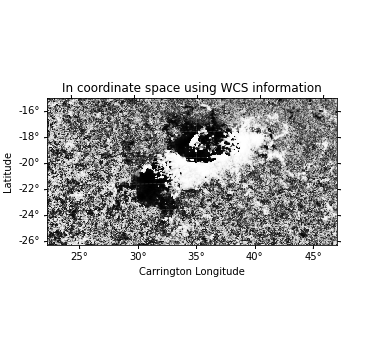
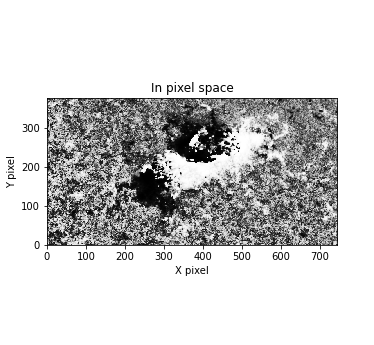
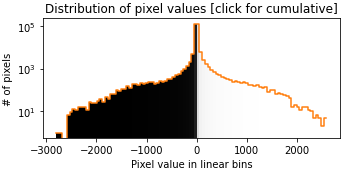
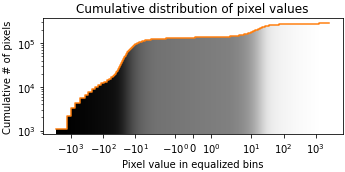

In [ ]:
Map(hmi_r)

# nf2 -> npy (time-consuming)

In [ ]:
state = torch.load(nf2_path, map_location=device)

In [ ]:
meta_info = state['meta_info']

# Number
print(meta_info['harpnum'])
print(meta_info['noaa_ar'])

# Observation
print(meta_info['date-obs'])
print(meta_info['t_obs'])
print(meta_info['t_rec'])

# shape
print(state['cube_shape'])
print(meta_info['naxis1'], meta_info['naxis2'])

377
11158
2011-02-13T11:58:12.200
2011.02.13_11:59:53.716_TAI
2011.02.13_12:00:00.000_TAI
[296, 184, 160]
744 377


In [ ]:
b = load_cube(nf2_path, device, progress=True, strides=1)

100%|██████████| 8715/8715 [08:02<00:00, 18.06it/s]


In [ ]:
np.save(npy_path, b)

# Read npy

In [ ]:
B = np.load(npy_path)

In [ ]:
Bx = B[:, :, :, 0]
By = B[:, :, :, 1]
Bz = B[:, :, :, 2]

In [ ]:
bstack = np.stack([Bx, By, Bz], axis=-1)
print(bstack.shape)
print(np.array_equal(bstack[..., 0], Bx))
print(np.array_equal(bstack[..., 1], By))
print(np.array_equal(bstack[..., 2], Bz))

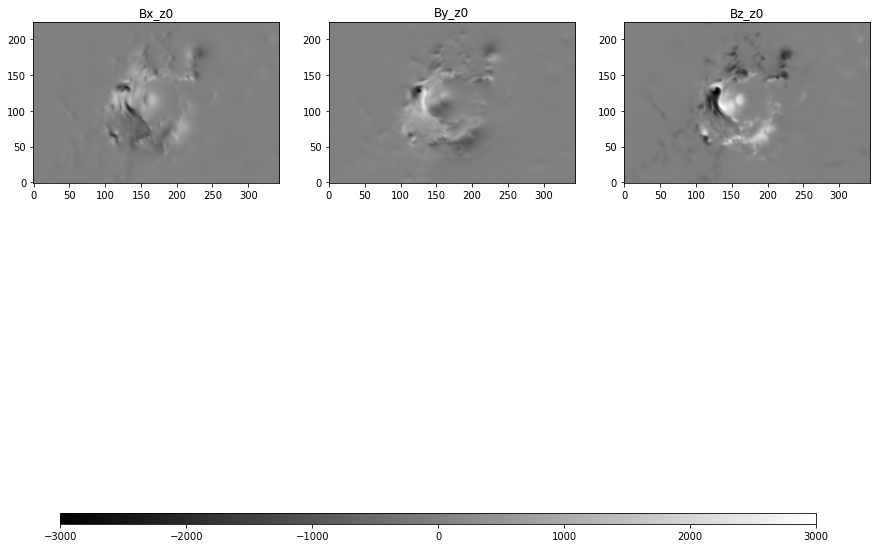

In [ ]:
Bx_z0 = Bx[:, :, 0].transpose()
By_z0 = By[:, :, 0].transpose()
Bz_z0 = Bz[:, :, 0].transpose()

vmax = 3000
vmin = -3000

fig, axes = plt.subplots(1,3, figsize=(15, 15))
im = axes[0].imshow(Bx_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Bx_z0')
axes[1].imshow(By_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('By_z0')
axes[2].imshow(Bz_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[2].set_title('Bz_z0')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.1, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Read nc

In [ ]:
nlff = nlfff(nc_path)

In [ ]:
nlff.info()

In [ ]:
nlff.plot()

# npy VS nc

In [ ]:
Br = Map(hmi_r).data

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


Text(0.5, 1.0, 'Observation (Br)')

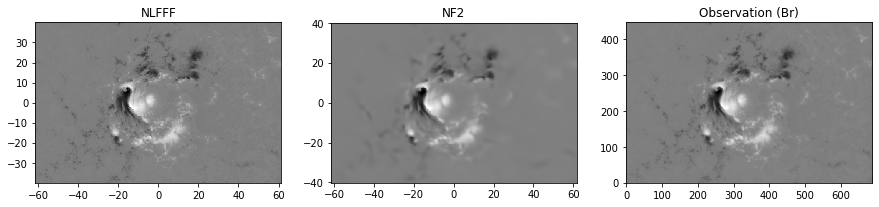

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].pcolormesh(nlff.x, nlff.y, nlff.bz[:,:,0].transpose(), vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[0].set_aspect('equal')
axes[0].set_title('NLFFF')

ny, nx = np.shape(Bz_z0)
bin = 1
Mm_per_pixel = 360e-3 * bin
x = np.arange(nx) * Mm_per_pixel
x = x - max(x)/2
y = np.arange(ny) * Mm_per_pixel
y = y - max(y)/2
axes[1].pcolormesh(x, y, Bz[:,:,0].transpose(), vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1].set_aspect('equal')
axes[1].set_title('NF2')

axes[2].imshow(Br, origin='lower', cmap='gist_gray', vmin=vmin, vmax=vmax)
axes[2].set_title('Observation (Br)')

In [ ]:
print(max(nlff.x) - min(nlff.x))
print(max(x) - min(x))

print(max(nlff.y) - min(nlff.y))
print(max(y) - min(y))

122.77860546844127
123.47999999999999
79.94885981210871
80.28


In [ ]:
print(len(nlff.x), len(nlff.y), len(nlff.z)) #NLFFF
print(state['cube_shape']) #NF2
print(meta_info['naxis1'], meta_info['naxis2']) #Original

513 257 257
[296, 184, 160]
744 377


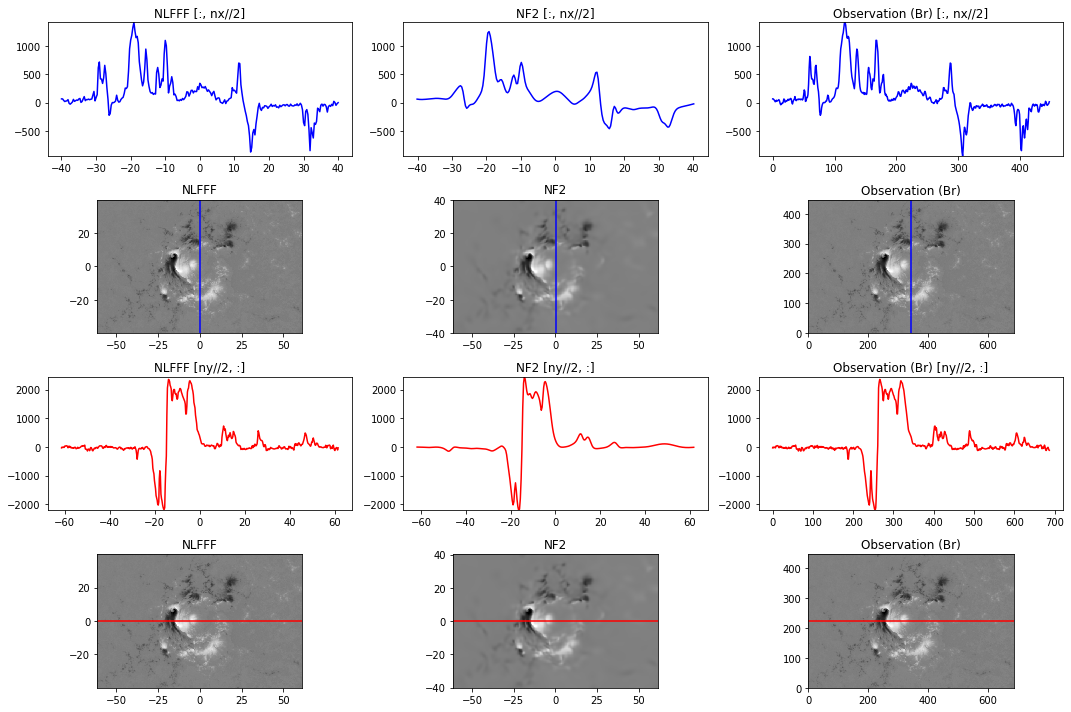

In [ ]:
nlf0 = nlff.bz[:,:,0].transpose()
ny1, nx1 = np.shape(nlf0)

nf20 = Bz[:,:,0].transpose()
ny2, nx2 = np.shape(nf20)

ob0 = Br
ny3, nx3 = np.shape(ob0)

max1 = max(max(nlf0[:, nx1//2]), max(nf20[:, nx2//2]), max(ob0[:, nx3//2]))
min1 = min(min(nlf0[:, nx1//2]), min(nf20[:, nx2//2]), min(ob0[:, nx3//2]))

max2 = max(max(nlf0[ny1//2, :]), max(nf20[ny2//2, :]), max(ob0[ny3//2, :]))
min2 = min(min(nlf0[ny1//2, :]), min(nf20[ny2//2, :]), min(ob0[ny3//2, :]))

fig, axes = plt.subplots(4,3, figsize=(15, 10))

#---------------------------------------------
axes[0,0].plot(nlff.y, nlf0[:, nx1//2], color='blue')
axes[0,0].set_title('NLFFF [:, nx//2]')
axes[0,0].set_ylim((min1, max1))

axes[1,0].pcolormesh(nlff.x, nlff.y, nlf0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,0].set_aspect('equal')
axes[1,0].set_title('NLFFF')
axes[1,0].axvline(nlff.x[nx1//2], color='blue')

axes[2,0].plot(nlff.x, nlf0[ny1//2, :], color='red')
axes[2,0].set_title('NLFFF [ny//2, :]')
axes[2,0].set_ylim((min2, max2))

axes[3,0].pcolormesh(nlff.x, nlff.y, nlf0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,0].set_aspect('equal')
axes[3,0].set_title('NLFFF')
axes[3,0].axhline(nlff.y[ny1//2], color='red')

#---------------------------------------------
Mm_per_pixel = 360e-3
x = np.arange(nx2) * Mm_per_pixel
x = x - max(x)/2
y = np.arange(ny2) * Mm_per_pixel
y = y - max(y)/2

axes[0,1].plot(y, nf20[:, nx2//2], color='blue')
axes[0,1].set_title('NF2 [:, nx//2]')
axes[0,1].set_ylim((min1, max1))

axes[1,1].pcolormesh(x, y, nf20, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,1].set_aspect('equal')
axes[1,1].set_title('NF2')
axes[1,1].axvline(x[nx2//2], color='blue')

axes[2,1].plot(x, nf20[ny2//2, :], color='red')
axes[2,1].set_title('NF2 [ny//2, :]')
axes[2,1].set_ylim((min2, max2))

axes[3,1].pcolormesh(x, y, nf20, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,1].set_aspect('equal')
axes[3,1].set_title('NF2')
axes[3,1].axhline(y[ny2//2], color='red')

#---------------------------------------------
x = np.arange(nx3)
y = np.arange(ny3)

axes[0,2].plot(y, ob0[:, nx3//2], color='blue')
axes[0,2].set_title('Observation (Br) [:, nx//2]')
axes[0,2].set_ylim((min1, max1))

axes[1,2].pcolormesh(x, y, ob0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,2].set_aspect('equal')
axes[1,2].set_title('Observation (Br)')
axes[1,2].axvline(x[nx3//2], color='blue')

axes[2,2].plot(x, ob0[ny3//2, :], color='red')
axes[2,2].set_title('Observation (Br) [ny//2, :]')
axes[2,2].set_ylim((min2, max2))

axes[3,2].pcolormesh(x, y, ob0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,2].set_aspect('equal')
axes[3,2].set_title('Observation (Br)')
axes[3,2].axhline(y[ny3//2], color='red')

fig.tight_layout()